In [1]:
## Using API pagination to query data from Buildings_2023_with_DINS.  
## Batch_size=2000 is the maximum record return limit set by ArcGIS REST.
## See the following link for the GeoJSON file with the first 2000 features:
## https://services.arcgis.com/RmCCgQtiZLDCtblq/ArcGIS/rest/services/Buildings_2023_with_DINS/FeatureServer/4/query?where=1%3D1&outFields=*&f=geojson
## Also worth looking at the following JSON file, e.g. for spatial reference:
## https://services.arcgis.com/RmCCgQtiZLDCtblq/ArcGIS/rest/services/Buildings_2023_with_DINS/FeatureServer/4/query?where=1%3D1&outFields=*&f=json
## Note that this data includes buildings that are in both the Eaton and Palisades regions.
## Later on we will restrict to the Eaton fire zone only.

import requests
import math
import time

url = "https://services.arcgis.com/RmCCgQtiZLDCtblq/ArcGIS/rest/services/Buildings_2023_with_DINS/FeatureServer/4/query"

batch_size = 2000

# Get total count of features
count_params = {
    "where": "1=1",
    "returnCountOnly": "true",
    "f": "json"
}
count_response = requests.get(url, params=count_params)
total_count = count_response.json().get("count", 0)
print(f"Total features to fetch: {total_count}")

# Calculate the number of batches needed
num_batches = math.ceil(total_count / batch_size)
print(f"Number of batches to fetch: {num_batches}")

all_features = []

# Fetch the batches 
for i in range(num_batches):
    params = {
        "where": "1=1",
        "outFields": "*",
        "f": "geojson",
        "resultOffset": i * batch_size,
        "resultRecordCount": batch_size
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    features = data.get("features", [])
    
    all_features.extend(features)
    print(f"Fetched batch {i+1}/{num_batches} with {len(features)} features, total so far: {len(all_features)}")
    
    time.sleep(0.2) 

print(f"Done. Total features fetched: {len(all_features)}")


Total features to fetch: 45428
Number of batches to fetch: 23
Fetched batch 1/23 with 2000 features, total so far: 2000
Fetched batch 2/23 with 2000 features, total so far: 4000
Fetched batch 3/23 with 2000 features, total so far: 6000
Fetched batch 4/23 with 2000 features, total so far: 8000
Fetched batch 5/23 with 2000 features, total so far: 10000
Fetched batch 6/23 with 2000 features, total so far: 12000
Fetched batch 7/23 with 2000 features, total so far: 14000
Fetched batch 8/23 with 2000 features, total so far: 16000
Fetched batch 9/23 with 2000 features, total so far: 18000
Fetched batch 10/23 with 2000 features, total so far: 20000
Fetched batch 11/23 with 2000 features, total so far: 22000
Fetched batch 12/23 with 2000 features, total so far: 24000
Fetched batch 13/23 with 2000 features, total so far: 26000
Fetched batch 14/23 with 2000 features, total so far: 28000
Fetched batch 15/23 with 2000 features, total so far: 30000
Fetched batch 16/23 with 2000 features, total so fa

In [2]:
import geopandas as gpd

gdf_buildings = gpd.GeoDataFrame.from_features(all_features)
print(gdf_buildings.shape)

(45428, 15)


In [3]:
print(gdf_buildings.crs)

None


In [4]:
## In the above, the GeoDataFrame gdf_buildings doesn't have a set Coordinate Reference System (CRS).
## The Buildings_2023_with_DINS page, as well its JSON file, specified its CRS to be 102100 (3857).
## However, by examining the coordinates here, we see that it's in the longitude/latitude form, 
## meaning that the GeoJSON data we got was transformed to EPSG:4326, not in EPSG:3857.

import json
from pprint import pprint

# Inspect the first geometry
pprint(all_features[0]["geometry"])


{'coordinates': [[[-118.516845655542, 34.0306253153194],
                  [-118.516798642051, 34.0305619851736],
                  [-118.516831969611, 34.0305448322829],
                  [-118.516798888046, 34.0305002936607],
                  [-118.516812541302, 34.0304932555065],
                  [-118.516818399235, 34.0305011170868],
                  [-118.516860412581, 34.0304794761116],
                  [-118.516863341091, 34.0304834204257],
                  [-118.516866992666, 34.0304815359039],
                  [-118.516877643242, 34.0304958896755],
                  [-118.516873563148, 34.030497995106],
                  [-118.516922054657, 34.0305632427769],
                  [-118.516877212085, 34.0305863248243],
                  [-118.5168860646, 34.0305983062322],
                  [-118.516845655542, 34.0306253153194]]],
 'type': 'Polygon'}


In [5]:
## Now that we know the data is in EPSG:4326, we set that as the CRS
gdf_buildings=gdf_buildings.set_crs(epsg=4326)
print(gdf_buildings.crs)

EPSG:4326


In [6]:
## Transform it to a projected CRS that is EPSG:26911, measured in meters, suitable for distance modeling in LA County.
gdf_buildings = gdf_buildings.to_crs(epsg=26911)
print(gdf_buildings.crs)

EPSG:26911


In [7]:
## Quick check for building bounds in this coordinate
print(gdf_buildings.total_bounds)

[ 344245.33210942 3766441.74254903  406222.23349344 3788429.25006518]


In [8]:
## defining a GeoDataFrame for the Eaton Fire perimeter from LA County GIS hub's Eaton Fire Perimeter's GeoJSON url 
gdf_firezone=gpd.read_file("https://services.arcgis.com/RmCCgQtiZLDCtblq/arcgis/rest/services/Palisades_and_Eaton_Dissolved_Fire_Perimeters_as_of_20250121/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

In [9]:
print(gdf_firezone.head())

   OBJECTID            type   Shape__Area  Shape__Length  \
0         1  Heat Perimeter   2206.265625     270.199719   
1         2  Heat Perimeter  20710.207031     839.204218   
2         3  Heat Perimeter   3639.238281     250.304502   
3         4  Heat Perimeter   1464.550781     148.106792   
4         5  Heat Perimeter   4132.753906     247.960744   

                                            geometry  
0  POLYGON ((-118.10094 34.16681, -118.1009 34.16...  
1  POLYGON ((-118.13596 34.17789, -118.13593 34.1...  
2  POLYGON ((-118.15626 34.18045, -118.15643 34.1...  
3  POLYGON ((-118.08442 34.1809, -118.08445 34.18...  
4  POLYGON ((-118.15659 34.18148, -118.15659 34.1...  


In [10]:
## check firezone data's CRS
print(gdf_firezone.crs)

EPSG:4326


In [11]:
## Set firezone data's CRS to EPSG 26911
gdf_firezone=gdf_firezone.to_crs(epsg=26911)
print(gdf_firezone.crs)

EPSG:26911


In [12]:
# Extract a single geometry from the series in gdf_firezone
fire_geom = gdf_firezone.geometry.union_all()

In [13]:
## Use the following commented out code in case one wants to buffer the fire zone, say by 60 meters ≈ 200 feet


#gdf_firebuffer = gdf_firezone.buffer(60)
#fire_geom = gdf_firebuffer.geometry.union_all()



In [14]:
## Intersect gdf_buildings with the firezone geometry
gdf_eaton_buildings = gdf_buildings[gdf_buildings.intersects(fire_geom)]

In [15]:
## Check to see how many buildings there are, a lot less than the 45248 buildings we started with.
print(gdf_eaton_buildings.shape)

(13449, 15)


In [16]:
## The next goal is to exclude buildings that are no inspected.  
## In the next few cells, we figure out how that information is recorded in the data.

print(gdf_eaton_buildings.columns)

Index(['geometry', 'OBJECTID', 'CODE', 'BLD_ID', 'HEIGHT', 'ELEV', 'SOURCE',
       'DATE_', 'STATUS', 'OLD_BLD_ID', 'AREA', 'DAMAGE', 'STRUCTURET',
       'Shape__Area', 'Shape__Length'],
      dtype='object')


In [17]:
print(gdf_eaton_buildings["DAMAGE"].unique())

['Destroyed (>50%)' 'No Damage' None 'Affected (1-9%)' 'Minor (10-25%)'
 'Major (26-50%)' 'Inaccessible']


In [18]:
print(gdf_eaton_buildings["STATUS"].unique())

['Unchanged' 'Modified' 'New' 'Replacement']


In [19]:
## Now that we know that the uninspected buildings are listed under the "DAMAGE" column as null or "Inaccessible"
## We can exclude them.

gdf_eaton_buildings_inspected = gdf_eaton_buildings[
    gdf_eaton_buildings["DAMAGE"].notna() & 
    (gdf_eaton_buildings["DAMAGE"] != "Inaccessible")
]

In [20]:
## Check how many buildings we now have after all the exclusions

print(gdf_eaton_buildings_inspected.shape)

(12658, 15)


In [21]:
print(gdf_eaton_buildings_inspected["DAMAGE"].unique())

['Destroyed (>50%)' 'No Damage' 'Affected (1-9%)' 'Minor (10-25%)'
 'Major (26-50%)']


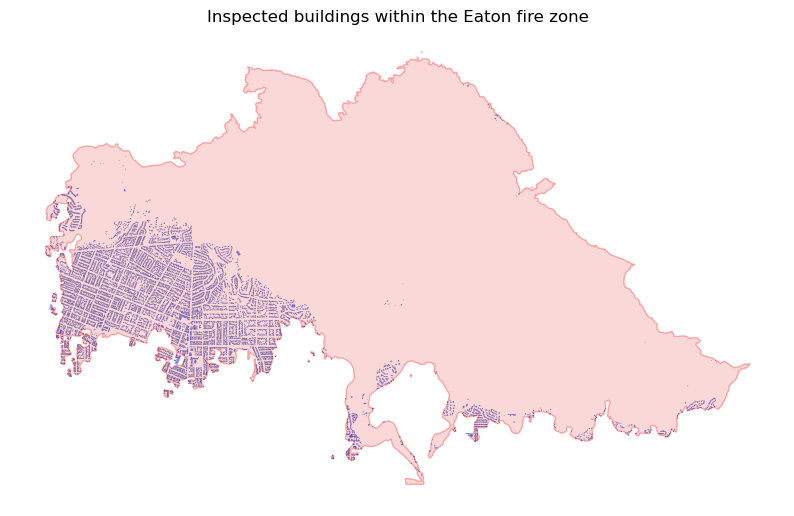

In [22]:
## Do a very rough plot to visualize gdf_eaton_buildings_inspected with repect to the fire perimeter
## If one wants to plot the buffered firezone, then use gdf_firebuffer instead of gdf_firezone

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot firezone 
gdf_firezone.plot(ax=ax, color='lightcoral', edgecolor='red', alpha=0.3)

# Plot selected buildings
gdf_eaton_buildings_inspected.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', linewidth=0.1)

plt.title("Inspected buildings within the Eaton fire zone")
plt.axis('off')
plt.savefig("rough_plot.png", bbox_inches='tight', dpi=300)
plt.show()

In [24]:
gdf_eaton_buildings_inspected.to_file("eaton_buildings.geojson", driver="GeoJSON")